In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time
from imblearn.under_sampling import RandomUnderSampler
from itertools import izip, combinations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [4]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

In [13]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

### Downsampling

In [14]:
# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [15]:
rds = RandomUnderSampler()
X_downsampled, y_downsampled = rds.fit_resample(X, y)

In [16]:
# Recreate dataframe
X_downsampled = pd.DataFrame(data=X_downsampled, columns=X.columns)
y_downsampled = pd.DataFrame(data=y_downsampled, columns=['DeviceType'])

# Onehot encode 'DeviceType'
devicetype_series = pd.get_dummies(y_downsampled['DeviceType'])
y_downsampled = pd.concat([y_downsampled, devicetype_series], axis=1)
y_downsampled = y_downsampled.drop(['DeviceType'],axis=1)

# Combine X and y into one dataframe
df_train_downsampled = pd.concat([X_downsampled, y_downsampled], axis=1)

### Plots

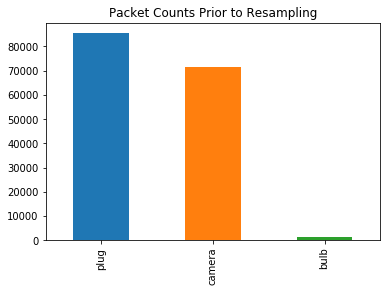

In [26]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

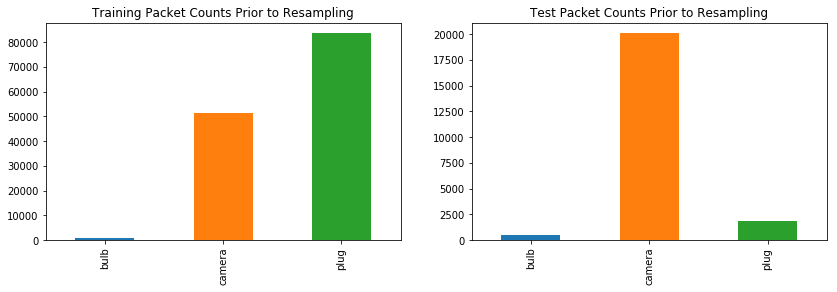

In [60]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


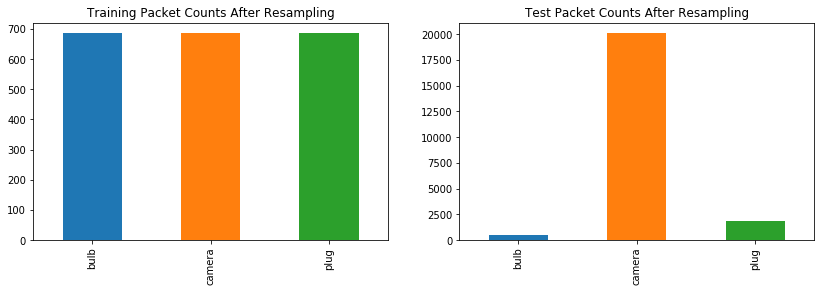

In [61]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");


# Run All vs One classification

In [62]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", 
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

In [63]:
# Reinsert Set and DeviceType columns to training dataset
df_train_downsampled['Set'] = 'train'

# Ensure same number of columns in both training and test datasets
train_cols = df_train_downsampled.columns
df_test_samecols = df_test[train_cols]

# Combine training and test sets into one dataframe
df_downsampled = pd.concat([df_train_downsampled,df_test_samecols],axis=0)

In [64]:
one_under_devtype = w.one_vs_one_classify(df_downsampled, features_list, y_list)

/root/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb         545       0
camera     17156    2961 

RF Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall
bulb        0  17156  2961   545  0.169683   0.030789  1.000000
camera  17156      0   545  2961  0.169683   1.000000  0.147189 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        537       8
camera       59   20058 

KNN Metrics
        FN  FP     TN     TP  Accuracy  Precision    Recall
bulb     8  59  20058    537  0.996757   0.901007  0.985321
camera  59   8    537  20058  0.996757   0.999601  0.997067 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        545       0
camera     5844   14273 

LDA Metrics
          FN    FP     TN     TP  Accuracy  Precision    Recall
bulb       0  5844  14273

In [65]:
all_over_device = w.one_vs_all_classify(df_downsampled, features_list, y_list)

Device Type: camera
RF

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       2399  17718
rest          166   2249

Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall
camera  17718    166  2249  2399  0.206284   0.935283  0.119252
rest      166  17718  2399  2249  0.206284   0.112636  0.931263
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       3157  16960
rest           24   2391

Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall
camera  16960     24  2391  3157  0.246228   0.992455  0.156932
rest       24  16960  3157  2391  0.246228   0.123560  0.990062
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       1134  18983
rest          103   2312

Metrics
           FN     FP    TN    TP  Accuracy  Precision   Recall
camera  18983    103  231

# OLD CODE BELOW

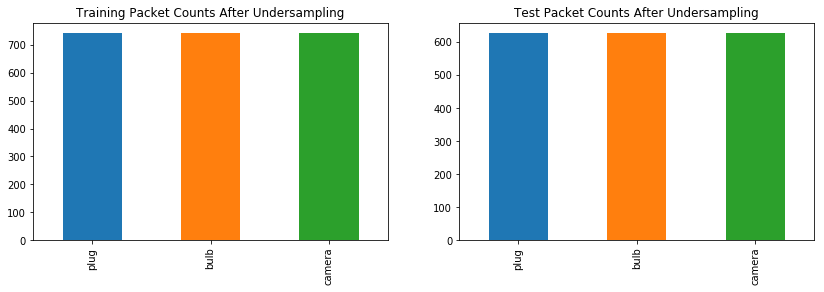

In [9]:
# 1st technique - Random undersampling: 
#     randomly removing packets of the majority classes to match the minority class

kind = "under"
category = "DeviceType"
df_train_undersampled = w.resample(df_train, kind=kind, category=category)
df_test_undersampled = w.resample(df_test, kind=kind, category=category)

# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Undersampling");

plt.subplot(1, 2, 2)
df_test_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Undersampling");

Oversampling DeviceType

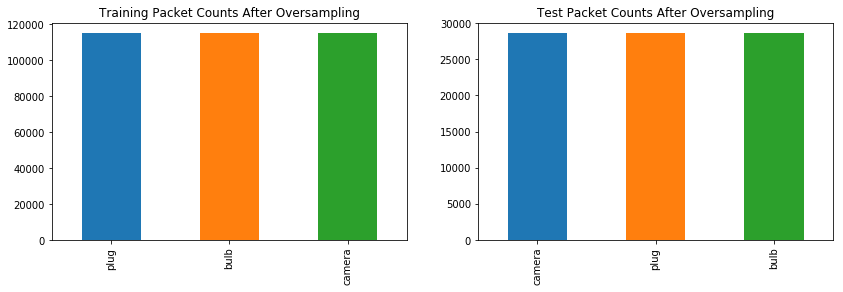

In [10]:
# 2nd technique - Random oversampling: 
#     randomly resampling packets of the minority classes to match the count of the majority class
kind = "over"
category = "DeviceType"
df_train_oversampled = w.resample(df_train, kind=kind, category=category)
df_test_oversampled = w.resample(df_test, kind=kind, category=category)


# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Oversampling");

plt.subplot(1, 2, 2)
df_test_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Oversampling");

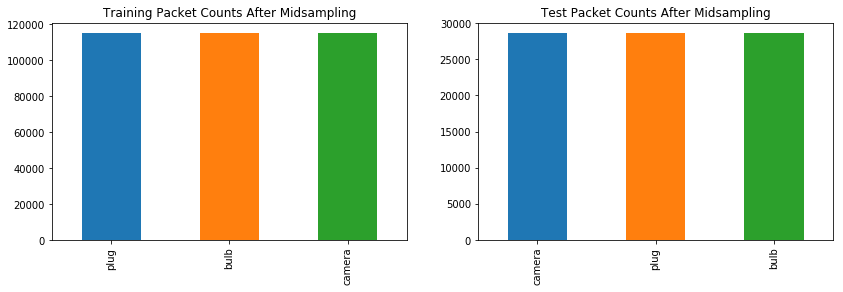

In [11]:
# 3rd technique - Random midsampling: 
#     randomly resampling packets of the minority classes to match the count of the majority class
kind = "mid"
category = "DeviceType"
df_train_midsampled = w.resample(df_train, kind=kind, category=category)
df_test_midsampled = w.resample(df_test, kind=kind, category=category)

# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Midsampling");

plt.subplot(1, 2, 2)
df_test_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Midsampling");

**Create feature list**

In [12]:
# Run One vs All  and One vs One classification strategies
features_list = [
        # Packet info
        "PacketLength", "Duration", 
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

y_list = ["camera", "bulb", "plug"]

Running classification

Undersampling and Oversampling by DeviceType

In [13]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs one: undersampling by DeviceType\n"
# test_one_vs_one_classify(df_undersample, features_list, y_list)
one_under_devtype = w.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by DeviceType

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        627       0
camera       19     608 

RF Metrics
        FN  FP   TN   TP  Accuracy  Precision    Recall
bulb     0  19  608  627  0.984848   0.970588  1.000000
camera  19   0  627  608  0.984848   1.000000  0.969697 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        626       1
camera       20     607 

KNN Metrics
        FN  FP   TN   TP  Accuracy  Precision    Recall
bulb     1  20  607  626  0.983254   0.969040  0.998405
camera  20   1  626  607  0.983254   0.998355  0.968102 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        627       0
camera      169     458 

LDA Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
bulb      0  169  458  627  0.

In [14]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs all: undersampling by DeviceType\n"
# test_one_vs_all_classify(df_undersample, features_list, y_list)
one_under_devtype = w.one_vs_all_classify(df_undersample, features_list, y_list)

One vs all: undersampling by DeviceType

Device Type: camera
RF

Confusion Matrix
Predicted  camera  rest
Actual                 
camera         90   537
rest           81  1173

Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  537   81  1173    90  0.671451   0.526316  0.143541
rest     81  537    90  1173  0.671451   0.685965  0.935407
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  camera  rest
Actual                 
camera        203   424
rest          213  1041

Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  424  213  1041   203   0.66135   0.487981  0.323764
rest    213  424   203  1041   0.66135   0.710580  0.830144
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  camera  rest
Actual                 
camera         38   589
rest           43  1211

Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
camera  589   43  1211 

In [15]:
df_oversample = pd.concat([df_train_oversampled, df_test_oversampled], axis=0)
print "One vs one: oversampling by DeviceType\n"
# test_one_vs_one_classify(df_oversample, features_list, y_list)
w.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by DeviceType

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb       28620       0
camera        12   28608 

RF Metrics
        FN  FP     TN     TP  Accuracy  Precision    Recall
bulb     0  12  28608  28620   0.99979   0.999581  1.000000
camera  12   0  28620  28608   0.99979   1.000000  0.999581 

--------------------------
KNN Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb       28323     297
camera         4   28616 

KNN Metrics
         FN   FP     TN     TP  Accuracy  Precision    Recall
bulb    297    4  28616  28323  0.994741   0.999859  0.989623
camera    4  297  28323  28616  0.994741   0.989728  0.999860 

--------------------------
LDA Confusion Matrix
Predicted   bulb  camera
Actual                  
bulb       28620       0
camera      8214   20406 

LDA Metrics
          FN    FP     TN     TP  Accuracy  Pre

({('bulb', 'plug'): {'KNN': {'CM': Predicted   bulb   plug
    Actual                 
    bulb       28510    110
    plug        6040  22580,
    'Classifier': {'Pred': array([0, 0, 0, ..., 1, 1, 1], dtype=uint8),
     'Pred_Proba': array([[1., 0.],
            [1., 0.],
            [1., 0.],
            ...,
            [0., 1.],
            [0., 1.],
            [0., 1.]]),
     'Score': 0.8925576519916143,
     'Time': 117.67456197738647,
     'True': 15229     0
     16467     0
     17081     0
     16611     0
     14747     0
     16815     0
     16419     0
     16264     0
     16939     0
     16044     0
     15228     0
     15656     0
     15445     0
     15338     0
     16187     0
     16025     0
     14991     0
     15038     0
     16276     0
     15286     0
     16144     0
     16468     0
     15025     0
     16886     0
     15348     0
     15652     0
     15865     0
     15944     0
     15165     0
     15023     0
              ..
     255217    1


In [16]:
print "One vs all: oversampling by DeviceType\n"
all_over_devtype = w.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by DeviceType

Device Type: camera
RF

Confusion Matrix
Predicted  camera   rest
Actual                  
camera      21585   7035
rest         7784  49456

Metrics
          FN    FP     TN     TP  Accuracy  Precision    Recall
camera  7035  7784  49456  21585  0.827405   0.734959  0.754193
rest    7784  7035  21585  49456  0.827405   0.875467  0.864011
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       7473  21147
rest          899  56341

Metrics
           FN     FP     TN     TP  Accuracy  Precision    Recall
camera  21147    899  56341   7473  0.743233   0.892618  0.261111
rest      899  21147   7473  56341  0.743233   0.727093  0.984294
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       1926  26694
rest         1749  55491

Metrics
           FN     FP     TN     TP  Accura

In [17]:
df_midsample = pd.concat([df_train_midsampled, df_test_midsampled], axis=0)
print "One vs one: midsampling by DeviceType\n"
# test_one_vs_one_classify(df_oversample, features_list, y_list)
w.one_vs_one_classify(df_midsample, features_list, y_list)

One vs one: midsampling by DeviceType

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb       2793       0
camera        3    2790 

RF Metrics
        FN  FP    TN    TP  Accuracy  Precision    Recall
bulb     0   3  2790  2793  0.999463   0.998927  1.000000
camera   3   0  2793  2790  0.999463   1.000000  0.998926 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb       2764      29
camera        1    2792 

KNN Metrics
        FN  FP    TN    TP  Accuracy  Precision    Recall
bulb    29   1  2792  2764  0.994629   0.999638  0.989617
camera   1  29  2764  2792  0.994629   0.989720  0.999642 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb       2793       0
camera      771    2022 

LDA Metrics
         FN   FP    TN    TP  Accuracy  Precision    Recall
bulb      0  771  

({('bulb', 'plug'): {'KNN': {'CM': Predicted  bulb  plug
    Actual               
    bulb       2776    17
    plug        576  2217,
    'Classifier': {'Pred': array([0, 1, 0, ..., 1, 1, 1], dtype=uint8),
     'Pred_Proba': array([[1., 0.],
            [0., 1.],
            [1., 0.],
            ...,
            [0., 1.],
            [0., 1.],
            [0., 1.]]),
     'Score': 0.8938417472252058,
     'Time': 16.215296983718872,
     'True': 16223     0
     15019     0
     16431     0
     16102     0
     15985     0
     15810     0
     15226     0
     16624     0
     16600     0
     15810     0
     14811     0
     14855     0
     16389     0
     15270     0
     14900     0
     14536     0
     15936     0
     14690     0
     16679     0
     16295     0
     16034     0
     17073     0
     16296     0
     14877     0
     15074     0
     15692     0
     15302     0
     14626     0
     14956     0
     16510     0
              ..
     255527    1
     255

In [18]:
print "One vs all: midsampling by DeviceType\n"
w.one_vs_all_classify(df_midsample, features_list, y_list)

One vs all: midsampling by DeviceType

Device Type: camera
RF

Confusion Matrix
Predicted  camera  rest
Actual                 
camera        385  2408
rest          144  5442

Metrics
          FN    FP    TN    TP  Accuracy  Precision    Recall
camera  2408   144  5442   385  0.695429   0.727788  0.137845
rest     144  2408   385  5442  0.695429   0.693248  0.974221
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  camera  rest
Actual                 
camera        965  1828
rest          869  4717

Metrics
          FN    FP    TN    TP  Accuracy  Precision    Recall
camera  1828   869  4717   965  0.678124   0.526172  0.345507
rest     869  1828   965  4717  0.678124   0.720703  0.844433
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  camera  rest
Actual                 
camera        169  2624
rest          181  5405

Metrics
          FN    FP    TN    TP  Accuracy  Precision    Recall
camera  262

({'bulb': {'KNN': {'CM': Predicted  bulb  rest
    Actual               
    bulb       2764    29
    rest         13  5573,
    'Classifier': {'Pred': array([0, 0, 0, ..., 1, 1, 0], dtype=uint8),
     'Pred_Proba': array([[1.        , 0.        ],
            [0.66666667, 0.33333333],
            [1.        , 0.        ],
            ...,
            [0.        , 1.        ],
            [0.        , 1.        ],
            [1.        , 0.        ]]),
     'Score': 0.9949874686716792,
     'Time': 73.41740894317627,
     'True': 16223     0
     15019     0
     16431     0
     16102     0
     15985     0
     15810     0
     15226     0
     16624     0
     16600     0
     15810     0
     14811     0
     14855     0
     16389     0
     15270     0
     14900     0
     14536     0
     15936     0
     14690     0
     16679     0
     16295     0
     16034     0
     17073     0
     16296     0
     14877     0
     15074     0
     15692     0
     15302     0
     146

Undersampling and Oversampling by Name

In [26]:
df_undersample = df_name_undersample
print "One vs one: undersampling by Name\n"
one_under_name = w.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by Name

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        202       0
camera        0     404 

RF Metrics
        FN  FP   TN   TP  Accuracy  Precision  Recall
bulb     0   0  404  202       1.0        1.0     1.0
camera   0   0  202  404       1.0        1.0     1.0 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        202       0
camera        0     404 

KNN Metrics
        FN  FP   TN   TP  Accuracy  Precision  Recall
bulb     0   0  404  202       1.0        1.0     1.0
camera   0   0  202  404       1.0        1.0     1.0 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        181      21
camera        2     402 

LDA Metrics
        FN  FP   TN   TP  Accuracy  Precision   Recall
bulb    21   2  402  181  0.962046   0.989071  0.89

{('bulb', 'plug'): {'KNN': {'CM': Predicted  bulb  plug
   Actual               
   bulb        202     0
   plug        202   202,
   'Metrics':        FN   FP   TN   TP  Accuracy  Precision  Recall
   bulb    0  202  202  202  0.666667        0.5     1.0
   plug  202    0  202  202  0.666667        1.0     0.5},
  'LDA': {'CM': Predicted  bulb  plug
   Actual               
   bulb        202     0
   plug         23   381,
   'Metrics':       FN  FP   TN   TP  Accuracy  Precision    Recall
   bulb   0  23  381  202  0.962046   0.897778  1.000000
   plug  23   0  202  381  0.962046   1.000000  0.943069},
  'RF': {'CM': Predicted  bulb  plug
   Actual               
   bulb        202     0
   plug        202   202,
   'Metrics':        FN   FP   TN   TP  Accuracy  Precision  Recall
   bulb    0  202  202  202  0.666667        0.5     1.0
   plug  202    0  202  202  0.666667        1.0     0.5}},
 ('camera', 'bulb'): {'KNN': {'CM': Predicted  bulb  camera
   Actual                 
 

In [27]:
print "One vs All: undersampling by Name\n"
all_under_name = w.one_vs_all_classify(df_undersample, features_list, y_list)

One vs All: undersampling by Name

Device Type: camera
--------------------------
--------------------------
RF Confusion Matrix
Predicted  camera  rest
Actual                 
camera        172   232
rest          210   396 

RF Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
camera  232  210  396  172  0.562376   0.450262  0.425743
rest    210  232  172  396  0.562376   0.630573  0.653465 

--------------------------
KNN Confusion Matrix
Predicted  camera  rest
Actual                 
camera        139   265
rest          197   409 

KNN Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
camera  265  197  409  139  0.542574   0.413690  0.344059
rest    197  265  139  409  0.542574   0.606825  0.674917 

--------------------------
LDA Confusion Matrix
Predicted  camera  rest
Actual                 
camera         83   321
rest           14   592 

LDA Metrics
         FN   FP   TN   TP  Accuracy  Precision    Recall
camera  321   14  592   83  0.668317

{'bulb': {'KNN': {'CM': Predicted  bulb  rest
   Actual               
   bulb        202     0
   rest          9   799,
   'Metrics':       FN  FP   TN   TP  Accuracy  Precision    Recall
   bulb   0   9  799  202  0.991089   0.957346  1.000000
   rest   9   0  202  799  0.991089   1.000000  0.988861},
  'LDA': {'CM': Predicted  bulb  rest
   Actual               
   bulb        181    21
   rest          9   799,
   'Metrics':       FN  FP   TN   TP  Accuracy  Precision    Recall
   bulb  21   9  799  181  0.970297   0.952632  0.896040
   rest   9  21  181  799  0.970297   0.974390  0.988861},
  'RF': {'CM': Predicted  bulb  rest
   Actual               
   bulb        202     0
   rest        201   607,
   'Metrics':        FN   FP   TN   TP  Accuracy  Precision    Recall
   bulb    0  201  607  202   0.80099   0.501241  1.000000
   rest  201    0  202  607   0.80099   1.000000  0.751238}},
 'camera': {'KNN': {'CM': Predicted  camera  rest
   Actual                 
   camera      

In [ ]:
df_oversample = df_name_oversample
print "One vs one: oversampling by Name\n"
one_over_name = w.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by Name

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted    bulb  camera
Actual                   
bulb       104280       0
camera      30496  178064 

RF Metrics
           FN     FP      TN      TP  Accuracy  Precision    Recall
bulb        0  30496  178064  104280  0.902519   0.773728  1.000000
camera  30496      0  104280  178064  0.902519   1.000000  0.853778 

--------------------------
KNN Confusion Matrix
Predicted    bulb  camera
Actual                   
bulb       103096    1184
camera         36  208524 

KNN Metrics
          FN    FP      TN      TP  Accuracy  Precision    Recall
bulb    1184    36  208524  103096    0.9961   0.999651  0.988646
camera    36  1184  103096  208524    0.9961   0.994354  0.999827 

--------------------------
LDA Confusion Matrix
Predicted    bulb  camera
Actual                   
bulb       104280       0
camera      36327  172233 

LDA Metrics
     

In [ ]:
print "One vs all: oversampling by Name\n"
all_over_name = w.one_vs_all_classify(df_oversample, features_list, y_list)